In [1]:
from netCDF4 import Dataset
import netCDF4 as netcdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import xarray as xr
import xarray.ufuncs as xu

### 1st Method (xarray)

This notebook is a demonstration of how to read HF radar data. Specifically, the HFRADAR US East and Gulf Coast 6km Resolution Hourly RTV dataset. The dataset's THREDDS catalog can be found in the link below:

https://hfrnet-tds.ucsd.edu/thredds/HFRADAR_USEGC.html

The urls have to be modified accordingly to use a different dataset.

The easiest way to read, subset and analyze large datasets in python is by using xarray.

### 1. Read

Using THREDDS catalog is helpful especially when the dataset is very large. This dataset is about 100 GB and it is efficient to read and select the parameters of interest rather than downloading it. 

In [2]:
# import the whole dataset

aggr_url = "https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd"
data = xr.open_dataset(aggr_url)
data

<xarray.Dataset>
Dimensions:                (lat: 460, lon: 701, nv: 2, time: 81481, time_1: 1)
Coordinates:
  * lat                    (lat) float32 21.74 21.79 21.84 ... 46.39 46.44 46.49
  * lon                    (lon) float32 -97.88 -97.83 -97.77 ... -57.29 -57.23
  * time                   (time) datetime64[ns] 2012-01-01 ... 2021-06-02T14...
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables: (12/14)
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    ...                     ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
Attributes: (12/31)
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202106020300siohfruwlsrtvusegc6km
    date_created:              2021-06-02T04:54:15Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    ...                        ...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_East_and_Gulf_Coast_6km_...

### 2. Subset

So far we have imported the dataset which contains the whole domain (lon, lat) and time period (time). These three coordinates help us subset the dataset. In our case, the area of interest is Southern New England and the goal is to keep only data between specific longitudes and latitudes. Besides, we might need to study a specific time period. In this example I wanted to keep only data between 04-01-2021 and 05-24-2021.

You can see that subsetting a large dataset might take a considerable amount of time. In this example, it took about 1 minute to subset the HF radar dataset. 

In [3]:
# subset the dataset by keeping only our area of interest and a specific time period

min_lon = -75.
min_lat = 39.
max_lon = -69.
max_lat = 43.

mask_lon = (data.lon >= min_lon) & (data.lon <= max_lon)
mask_lat = (data.lat >= min_lat) & (data.lat <= max_lat)


%time subset_ds = data.sel(time=slice("2021-04-01", "2021-05-24")).where(mask_lon & mask_lat, drop=True)

Wall time: 1min 11s


In [4]:
subset_ds

<xarray.Dataset>
Dimensions:                (lat: 74, lon: 103, nv: 2, time: 1296, time_1: 1)
Coordinates:
  * lat                    (lat) float32 39.05 39.1 39.16 ... 42.88 42.93 42.99
  * lon                    (lon) float32 -74.94 -74.89 -74.83 ... -69.08 -69.02
  * time                   (time) datetime64[ns] 2021-04-01 ... 2021-05-24T23...
    time_run               (time) datetime64[ns] 2021-04-01 ... 2021-05-24T23...
Dimensions without coordinates: nv, time_1
Data variables: (12/14)
    time_bnds              (time_1, nv, lon, lat) float64 1.623e+09 ... 1.623...
    depth_bnds             (nv, lon, lat) float32 0.0 0.0 0.0 ... 2.4 2.4 2.4
    wgs84                  (lon, lat) float64 -127.0 -127.0 ... -127.0 -127.0
    processing_parameters  (lon, lat) float64 -127.0 -127.0 ... -127.0 -127.0
    radial_metadata        (lon, lat) float64 -127.0 -127.0 ... -127.0 -127.0
    depth                  (lon, lat) float64 1.4 1.4 1.4 1.4 ... 1.4 1.4 1.4
    ...                     ...
    v                      (time, lat, lon) float32 0.23 nan nan ... nan nan nan
    dopx                   (time, lat, lon) float32 0.09 nan nan ... nan nan nan
    dopy                   (time, lat, lon) float32 0.16 nan nan ... nan nan nan
    hdop                   (time, lat, lon) float32 0.19 nan nan ... nan nan nan
    number_of_sites        (time, lat, lon) float32 2.0 nan nan ... nan nan nan
    number_of_radials      (time, lat, lon) float32 177.0 nan nan ... nan nan
Attributes: (12/31)
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202106020300siohfruwlsrtvusegc6km
    date_created:              2021-06-02T04:54:15Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    ...                        ...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_East_and_Gulf_Coast_6km_...

### 3. Save (optional)

The HF radar dataset can also be saved as NetCDF file for future use.

In [5]:
subset_ds.to_netcdf(path='hf_radar_04-05_21.nc')

### 4. Select the closest gridpoint to the point of interest

This example is helpful for comparing gridded data with point observaions. In this example we want to compare HF radar data (gridded) with the closest ADCP sensor. The sensor's coordinates are lon=-70.88174, lat=40.36708. Therefore, we will keep only data from the closest gridpoint to the ADCP longitude and latitude. Indeed, you can see below that the closest HF radar gridpoint's coordinates are: lon: -70.88, lat=40.35, which is located about 200 meters in longitude and 2 kilometers in latitude from the ADCP station.

In [6]:
data2 = subset_ds.sel(lon=-70.88174, lat=40.36708, method='nearest')
data2

<xarray.Dataset>
Dimensions:                (nv: 2, time: 1296, time_1: 1)
Coordinates:
    lat                    float32 40.35
    lon                    float32 -70.88
  * time                   (time) datetime64[ns] 2021-04-01 ... 2021-05-24T23...
    time_run               (time) datetime64[ns] 2021-04-01 ... 2021-05-24T23...
Dimensions without coordinates: nv, time_1
Data variables: (12/14)
    time_bnds              (time_1, nv) float64 1.623e+09 1.623e+09
    depth_bnds             (nv) float32 0.0 2.4
    wgs84                  float64 -127.0
    processing_parameters  float64 -127.0
    radial_metadata        float64 -127.0
    depth                  float64 1.4
    ...                     ...
    v                      (time) float32 nan nan nan nan ... 0.05 0.01 -0.02
    dopx                   (time) float32 nan nan nan nan ... 0.63 0.63 0.63
    dopy                   (time) float32 nan nan nan nan ... 0.81 0.81 0.81
    hdop                   (time) float32 nan nan nan nan ... 1.03 1.03 1.03
    number_of_sites        (time) float32 nan nan nan nan ... 3.0 3.0 3.0 3.0
    number_of_radials      (time) float32 nan nan nan nan ... 15.0 15.0 15.0
Attributes: (12/31)
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202106020300siohfruwlsrtvusegc6km
    date_created:              2021-06-02T04:54:15Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    ...                        ...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_East_and_Gulf_Coast_6km_...

If we take a look at the time series of the zonal (east-west) component, it is evident that there are gaps. We can deduce that this specific grid point is not the closest every time (hour) or that there are not available observations at this is specific gridpoint every hour. 

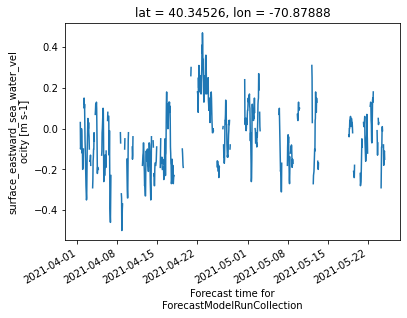

In [7]:
data2.u.plot()

### 5. Plot

For the visualization of the surface currents from HF radar, we have to select a specific time (hour). 

In [8]:
# select a specific date and time

#data1 = data.isel(time=81268)
data1 = subset_ds.sel(time='2021-05-24T23:00:00')
data1

<xarray.Dataset>
Dimensions:                (lat: 74, lon: 103, nv: 2, time_1: 1)
Coordinates:
  * lat                    (lat) float32 39.05 39.1 39.16 ... 42.88 42.93 42.99
  * lon                    (lon) float32 -74.94 -74.89 -74.83 ... -69.08 -69.02
    time                   datetime64[ns] 2021-05-24T23:00:00
    time_run               datetime64[ns] 2021-05-24T23:00:00
Dimensions without coordinates: nv, time_1
Data variables: (12/14)
    time_bnds              (time_1, nv, lon, lat) float64 1.623e+09 ... 1.623...
    depth_bnds             (nv, lon, lat) float32 0.0 0.0 0.0 ... 2.4 2.4 2.4
    wgs84                  (lon, lat) float64 -127.0 -127.0 ... -127.0 -127.0
    processing_parameters  (lon, lat) float64 -127.0 -127.0 ... -127.0 -127.0
    radial_metadata        (lon, lat) float64 -127.0 -127.0 ... -127.0 -127.0
    depth                  (lon, lat) float64 1.4 1.4 1.4 1.4 ... 1.4 1.4 1.4
    ...                     ...
    v                      (lat, lon) float32 0.5 nan nan nan ... nan nan nan
    dopx                   (lat, lon) float32 0.09 nan nan nan ... nan nan nan
    dopy                   (lat, lon) float32 0.17 nan nan nan ... nan nan nan
    hdop                   (lat, lon) float32 0.19 nan nan nan ... nan nan nan
    number_of_sites        (lat, lon) float32 2.0 nan nan nan ... nan nan nan
    number_of_radials      (lat, lon) float32 174.0 nan nan nan ... nan nan nan
Attributes: (12/31)
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202106020300siohfruwlsrtvusegc6km
    date_created:              2021-06-02T04:54:15Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    ...                        ...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_East_and_Gulf_Coast_6km_...

In [9]:
# calculate the magnitude of surface currents

CurrMag=np.sqrt(data1.u.values**2+data1.v.values**2)

In [10]:
# create the mesh for your plot
x, y = np.meshgrid(data1.lon.values,data1.lat.values)

# mask data
data_m = np.ma.masked_invalid(CurrMag)
u_m = np.ma.masked_invalid(data1.u.values)
v_m = np.ma.masked_invalid(data1.v.values)

<ipython-input-11-6a8ef54b3a47>:22: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)


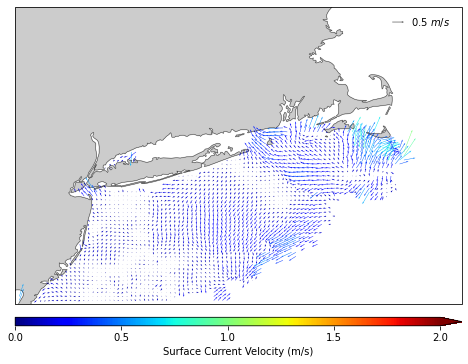

In [11]:
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([-75, -69, 39, 43])

ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)

bounds = np.array([0.,0.5,1.,1.5,2.])
norm = mpl.colors.Normalize(vmin=0., vmax=2.)

# plot current vectors
cf=ax.quiver(x,y,data1.u,data1.v,data_m,cmap=plt.cm.jet,scale=19,width=.001,norm=norm)

# add the scale for the currents magnitude
qk = ax.quiverkey(cf, 0.8, 0.58, 0.5, label='$0.5 \ m/s$', labelpos='E',
                   coordinates='figure')

# add colorbar
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.02,aspect=50)
out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)
out.set_label('Surface Current Velocity (m/s)',size=10)

plt.savefig('hf_radar.png', dpi=300, bbox_inches='tight')

### 2nd Method (netcdf library)

I also included an example of reading and plotting the HF radar data using the NetCDF python library because it is a very popular library primarily for reading NetCDF files and you might consider using it in the future.

In [12]:
# import dataset

netcdf_data = Dataset('https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd')


In [13]:
for variable in netcdf_data.variables:
    print(variable,netcdf_data.variables[variable].shape)

lat (460,)
lon (701,)
time (81481,)
time_run (81481,)
time_bnds (1, 2)
depth_bnds (2,)
wgs84 ()
processing_parameters ()
radial_metadata ()
depth ()
time_offset (81481,)
u (81481, 460, 701)
v (81481, 460, 701)
dopx (81481, 460, 701)
dopy (81481, 460, 701)
hdop (81481, 460, 701)
number_of_sites (81481, 460, 701)
number_of_radials (81481, 460, 701)


In [14]:
lat=netcdf_data.variables['lat'][:]
lon=netcdf_data.variables['lon'][:]
time=netcdf_data.variables['time'][:]

In [15]:
latest_time_index=int(len(time))-4

In [16]:
latest_time_index

81477

In [17]:
u=netcdf_data.variables['u'][latest_time_index,:,:];
v=netcdf_data.variables['v'][latest_time_index,:,:];

In [18]:
# calculate the currents magnitude

CurrMag=np.sqrt(u**2+v**2)

<ipython-input-20-bc18f35fd5e7>:31: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)


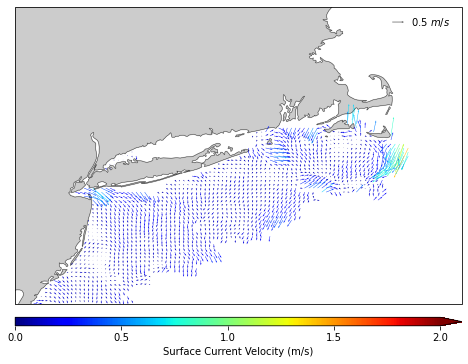

In [20]:
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([-75, -69, 39, 43])

ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)
bounds = np.array([0.,0.5,1.,1.5,2.])
norm = mpl.colors.Normalize(vmin=0., vmax=2.)

# convert the lat/lon values to x/y projections.
x, y = np.meshgrid(lon,lat)

# mask data
data_m = np.ma.masked_invalid(CurrMag)
u_m = np.ma.masked_invalid(u)
v_m = np.ma.masked_invalid(v)

#  plot current vectors
cf=ax.quiver(x,y,u,v,data_m,cmap=plt.cm.jet,scale=19,width=.001,norm=norm)
#cs2=ax.quiver(x,y,u,v,data_m,cmap=plt.cm.jet)
#plt.colorbar(CF,label="Speed (m/s)",orientation='horizontal')

qk = ax.quiverkey(cf, 0.8, 0.58, 0.5, label='$0.5 \ m/s$', labelpos='E',
                   coordinates='figure')


cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.02,aspect=50)

out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)
out.set_label('Surface Current Velocity (m/s)',size=10)

plt.savefig('hf_radar_alt.png', dpi=300, bbox_inches='tight')